## Table of Contents
[1.0 Import Statements](#Import-Statements)<br>
[2.0 Data Preparation](#Data-Preparation)<br>
[2.1 Label Encode Categorical Columns ](#categorical)<br>

### 1.0 Import Statements <a class="anchor" id="Import-Statements"></a>

In [29]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
import os




# Import split_data
os.chdir('../scripts')
from functions import split_data, sMAPE
os.chdir('../notebooks')

### 1.2 Import Functions

In [ ]:
def compute_metrics(model, X, y):
    model_preds = model.predict(X)
    print('r2 sklearn:', r2_score(y, model_preds))
    print('r2 numpy:', np.corrcoef(y, model_preds)[0][1]**2)
    print('sMAPE:', sMAPE(y, model_preds))


### 1.3 Import Data

In [2]:
df = pd.read_csv('../data/clean/df_clean.csv', index_col=0, parse_dates=True)
df_lag = pd.read_csv('../data/clean/df_clean_lag.csv', index_col=0, parse_dates=True)

### 2.0 Data Preparation <a class="anchor" id="Data-Preparation"></a>
### 2.1 Label Encode Categorical Columns <a class="anchor" id="categorical"></a>

In [3]:
# Get Categorical columns
categorical = df.select_dtypes(include='object')

# Instationate LabelEncoder, fit and transform on wind_direction cols
wind_dir_coder = LabelEncoder()
wind_dir_coder.fit(df['wind_madrid'])
for col in categorical.filter(regex='wind').columns:
    df[col] = wind_dir_coder.transform(df[col])
    

# Stack condition columns into single col
stacked_conditions = categorical.filter(regex='condition').stack()

# Instantiate Label encoder, fit and transform on condition cols
condition_coder = LabelEncoder()
condition_coder.fit(stacked_conditions)
for col in categorical.filter(regex='condition').columns:
    df[col] = condition_coder.transform(df[col])

## 2.2 Create mean weather cols

In [4]:
df['temp_mean']=df.filter(regex='temp').mean(axis=1)
df['dew_point_mean']=df.filter(regex='dew_point').mean(axis=1)
df['humidities_mean']=df.filter(regex='humidities').mean(axis=1)
df['dew_point_mean']=df.filter(regex='dew_point').mean(axis=1)
df['wind_speeds_mean']=df.filter(regex='wind_speeds').mean(axis=1)
df['pressures_mean']=df.filter(regex='pressures').mean(axis=1)

# 3 Modeling
## 3.1 Univariate Regression - Predict Average Price
## Remove Columns in Preparation for Univariate Regression

In [5]:
price_cols = df.filter(regex='price').columns.to_list()
price_cols.remove('price_actual')
data = df.drop(columns=price_cols)

## Multicolinearity

In [6]:
# Create correlation matrix
corr = data.drop(columns='price_actual').corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr_price = data.corr()['price_actual'].reset_index().sort_values('price_actual', ascending=False)

# Rename correlation column
corr.rename(columns={0:'cor'}, inplace=True)

# Remove correlation between same variables and duplicates
corr = corr.loc[corr['cor']!=1]
corr.drop_duplicates(subset='cor', inplace=True)
corr_price = corr_price.loc[corr_price['price_actual']!=1]

# Reset index
corr.reset_index(drop=True, inplace=True)
corr_price.reset_index(drop=True, inplace=True)

# Round
corr.cor =corr.cor.apply(lambda x: round(x,3))

In [7]:
corr.head(50)

,level_0,level_1,cor
0,load_actual,load_forecast,0.995
1,solar_forecast,solar,0.994
2,onshore,wind_forecast,0.986
3,temp_mean,temp_madrid,0.964
4,temp_mean,temp_barcelona,0.948
5,temp_valencia,temp_mean,0.942
6,temp_valencia,temp_barcelona,0.919
7,dew_point_mean,dew_point_barcelona,0.916
8,dew_point_mean,dew_point_valencia,0.910
9,temp_madrid,temp_barcelona,0.906


Get the pairs of variables highly correlated with each other, and for each pair, drop the one with the lower correlation with `price_actual`

In [8]:
drop = []
for row in range(len(corr.loc[corr.cor>.8])):
    var1 = corr.loc[row,'level_0']
    var2 = corr.loc[row,'level_1']
    
    # Get var corrs with price_tomorrow
    var1_corr = float(corr_price.loc[corr_price['index'] == var1, 'price_actual'])
    var2_corr = float(corr_price.loc[corr_price['index'] == var2, 'price_actual'])
    
    # Add the lower correlation to the drop list
    if var1_corr > var2_corr:
        drop.append(var2)
    else:
        drop.append(var1)

Drop highly correlated weather columns

In [9]:
data.drop(columns=drop, inplace=True)

In [10]:
# Create correlation matrix
corr = data.drop(columns='price_actual').corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr_price = data.corr()['price_actual'].reset_index().sort_values('price_actual', ascending=False)

# Rename correlation column
corr.rename(columns={0:'cor'}, inplace=True)

# Remove correlation between same variables and duplicates
corr = corr.loc[corr['cor']!=1]
corr.drop_duplicates(subset='cor', inplace=True)
corr_price = corr_price.loc[corr_price['price_actual']!=1]

# Reset index
corr.reset_index(drop=True, inplace=True)
corr_price.reset_index(drop=True, inplace=True)

# Round
corr.cor =corr.cor.apply(lambda x: round(x,3))

In [11]:
corr_price

,index,price_actual
0,gas,0.367471
1,biomass,0.325826
2,renewable,0.208428
3,load_actual,0.175035
4,waste,0.139592
5,pressures_barcelona,0.086525
6,pressures_bilbao,0.066458
7,humidities_valencia,0.060381
8,solar_forecast,0.059381
9,humidities_bilbao,0.055781


In [12]:
corr.head(60)

,level_0,level_1,cor
0,wind_speeds_mean,wind_speeds_valencia,0.772
1,dew_point_valencia,dew_point_bilbao,0.762
2,humidities_valencia,humidities_mean,0.727
3,wind_speeds_madrid,wind_speeds_mean,0.722
4,coal,oil,0.665
5,transmission_fs,transmission_sf,0.661
6,wind_speeds_bilbao,wind_speeds_mean,0.638
7,poundage,reservoir,0.628
8,solar_forecast,humidities_mean,0.628
9,temp_seville,dew_point_bilbao,0.616


In [13]:
import matplotlib.pyplot as plt

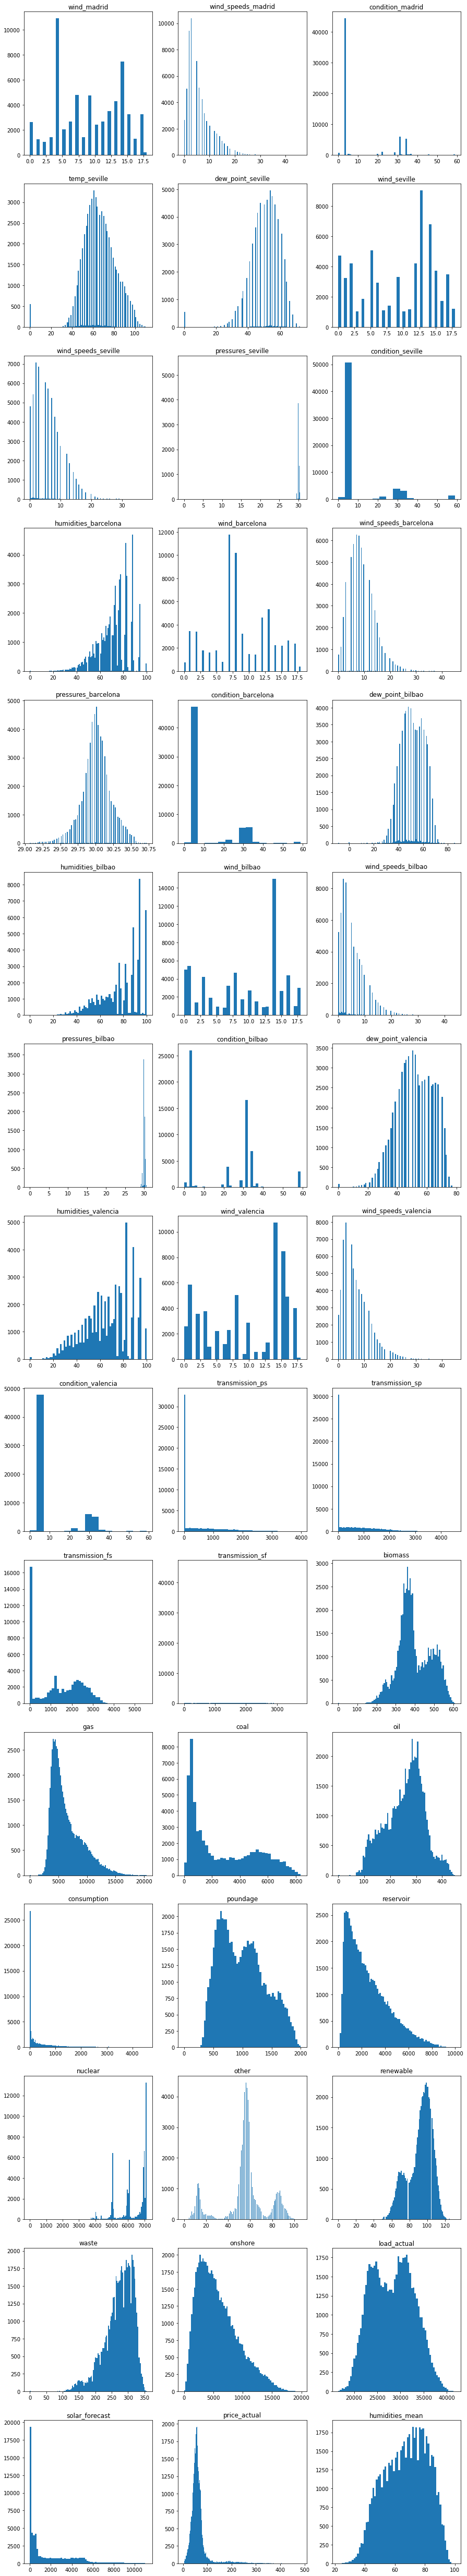

In [14]:
fig, axes = plt.subplots(nrows=data.shape[1]//3, ncols=3, figsize=(15,90));
for col, ax in zip(data.columns, axes.flatten()):
    ax.hist(data[col], bins='auto')
    ax.set_title(col)

## Split Data

In [31]:
X_train, y_train, X_val, y_val = split_data(data, 2020, 'price_actual')

## Linear Regression

In [34]:
X_train = sm.add_constant(X_train)
X_val = sm.add_constant(X_val)
lr_0 = sm.OLS(y_train, X_train).fit()
lr_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_actual   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     2233.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        13:26:54   Log-Likelihood:            -1.5140e+05
No. Observations:               43824   AIC:                         3.029e+05
Df Residuals:                   43779   BIC:                         3.033e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -83.5062      7.591    -11.001      0.000     -98.385     -68.628
wind_madrid              -0.0056      0.008     -0.674      0.500      -0.022       0.011
wind_speeds_madrid       -0.0519      0.010     -5.062      0.000      -0.072      -0.032
condition_madrid          0.0112      0.004      3.177      0.001       0.004       0.018
temp_seville             -0.0186      0.009     -2.072      0.038      -0.036      -0.001
dew_point_seville        -0.0095      0.009     -1.118      0.264      -0.026       0.007
wind_seville             -0.0428      0.008     -5.600      0.000      -0.058      -0.028
wind_speeds_seville      -0.0194      0.009     -2.192      0.028      -0.037      -0.002
pressures_seville         0.2183      0.167      1.307      0.191      -0.109       0.546
condition_seville        -0.0041      0.003     -1.221      0.222      -0.011       0.003
humidities_barcelona     -0.0258      0.005     -5.706      0.000      -0.035      -0.017
wind_barcelona           -0.0442      0.009     -5.076      0.000      -0.061      -0.027
wind_speeds_barcelona     0.0048      0.008      0.577      0.564      -0.012       0.021
pressures_barcelona       2.0564      0.308      6.671      0.000       1.452       2.661
condition_barcelona       0.0138      0.003      4.297      0.000       0.007       0.020
dew_point_bilbao         -0.0488      0.009     -5.397      0.000      -0.067      -0.031
humidities_bilbao        -0.0002      0.004     -0.045      0.964      -0.008       0.008
wind_bilbao              -0.0512      0.007     -7.701      0.000      -0.064      -0.038
wind_speeds_bilbao        0.0160      0.009      1.712      0.087      -0.002       0.034
pressures_bilbao          0.8461      0.164      5.144      0.000       0.524       1.169
condition_bilbao         -0.0324      0.003    -12.400      0.000      -0.037      -0.027
dew_point_valencia       -0.0021      0.009     -0.223      0.824      -0.020       0.016
humidities_valencia       0.0012      0.005      0.223      0.823      -0.010       0.012
wind_valencia            -0.0363      0.008     -4.781      0.000      -0.051      -0.021
wind_speeds_valencia      0.0356      0.009      3.886      0.000       0.018       0.054
condition_valencia       -0.0034      0.004     -0.958      0.338      -0.010       0.004
transmission_ps          -0.0015   9.83e-05    -15.644      0.000      -0.002      -0.001
transmission_sp           0.0003      0.000      3.229      0.001       0.000       0.001
transmission_fs          -0.0019   9.04e-05    -20.755      0.000      -0.002      -0.002
transmission_sf          -0.0002      0.000     -1.555      0.120      -0.000    4.29e-05
biomass                   0.0143      0.001     20.158      0.000       0.013       0.016
gas                    

### Model Metrics

In [35]:
compute_metrics(lr_0, X_val, y_val)

r2 sklearn: -0.6722643503672638
r2 numpy: 0.5749571995873908
sMAPE: 31.362104706714984


### Model Coefficients (Feature Importance)

In [36]:
# Get Coefficients, drop the const col, rename coefficient column
lr_0_coefs = lr_0.params.drop('const').to_frame()
lr_0_coefs.rename(columns={0:'coef'}, inplace=True)

# Create a flag for negative coefficients, take absolute value, sort descending
lr_0_coefs['key'] = lr_0_coefs['coef'].apply(lambda x: 'negative' if x<0 else 'positive')
lr_0_coefs.iloc[:, 0] = lr_0_coefs['coef'].apply(abs)
lr_0_coefs.sort_values(by='coef', ascending=False, inplace=True)

# Subset to the top 10 most influential variables
lr_0_coefs = lr_0_coefs.head(20).copy()

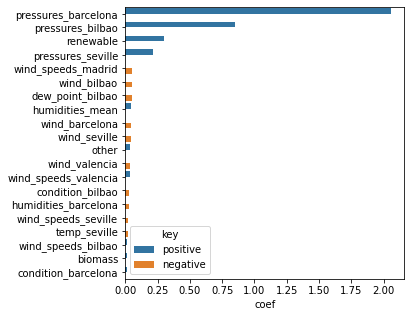

In [37]:
plt.figure(figsize=(5,5))
sns.barplot(x='coef', y=lr_0_coefs.index, data= lr_0_coefs, hue='key');

## Feature Selection with RFE

In [39]:
len(X_train.columns)

46

In [45]:
r_squared = []
for i in range(1, len(X_train.columns)):
    lr_1 = LinearRegression()
    selector = RFE(lr_1, n_features_to_select=i)
    selector = selector.fit(X_train, y_train)
    cols = X_train.columns[selector.support_]
    lr_1.fit(X_train[cols], y_train)

    preds = lr_1.predict(X_val[cols])
    r_squared.append(np.corrcoef(y_val, preds)[0][1]**2)

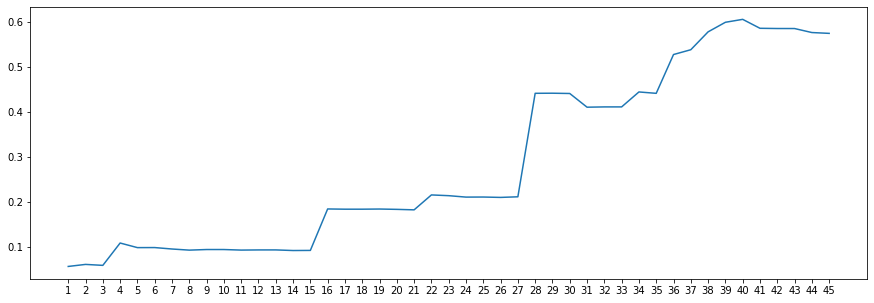

In [46]:
fig = plt.figure(figsize=(15,5))
plt.plot(range(1, len(X_train.columns)), r_squared);
plt.xticks(range(1,len(X_train.columns)));

After using on the first three most important features, linear regression begins to plateau.  We really don't achieve any better performance by adding the other features to the model. Now, I'll run a new model with only these three features.

In [47]:
lr_1 = LinearRegression()
selector = RFE(lr_1, n_features_to_select=40)
selector = selector.fit(X_train, y_train)
cols = X_train.columns[selector.support_]
lr_1.fit(X_train[cols], y_train)

LinearRegression()

In [51]:
# r2 score:
preds_lr_1 = lr_1.predict(X_val[cols])
print('r2 numpy:', np.corrcoef(preds_lr_1, y_val)[0][1]**2)
print('sMAPE:', sMAPE(preds_lr_1, y_val))

r2 numpy: 0.6061688820706007
sMAPE: 31.73522360820047


## Remove Price Actual

In [27]:
X_train = sm.add_constant(X_train)
lr_2 = sm.OLS(y_train, X_train.drop(columns='price_actual')).fit()
lr_2.summary()

KeyError: "['price_actual'] not found in axis"

## See what happens when add in features one by one

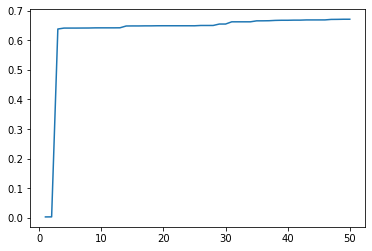

In [27]:
r_squared = []
for i in range(1, len(X_train.drop(columns='price_today').columns)):
    lr_2 = LinearRegression()
    selector = RFE(lr_2, n_features_to_select=i)
    selector = selector.fit(X_train.drop(columns='price_today'), y_train)
    cols = X_train.drop(columns='price_today').columns[selector.support_]
    lr_2.fit(X_train[cols], y_train)

    preds = lr_2.predict(X_val[cols])
    r_squared.append(r2_score(y_val, preds))
    
plt.plot(range(1, len(X_train.drop(columns='price_today').columns)), r_squared);

## Interactions

In [54]:
df

,temp_madrid,dew_point_madrid,humidities_madrid,wind_madrid,wind_speeds_madrid,pressures_madrid,condition_madrid,temp_seville,dew_point_seville,humidities_seville,...,price_P0146_balance,price_generic_failure,price_interupt_service,price_power_factor,price_balance_failure,temp_mean,dew_point_mean,humidities_mean,wind_speeds_mean,pressures_mean
2015-01-01 00:00:00,30.0,25.0,80.0,9,2.0,28.40,4,37.000000,32.0,81.0,...,0.02,0.0,1.69,-0.07,0.00,36.200000,31.2,82.2,4.400000,29.962
2015-01-01 01:00:00,30.0,25.0,80.0,13,3.0,28.43,4,37.000000,32.0,81.0,...,0.01,0.0,1.69,-0.07,0.00,35.400000,30.8,83.4,4.600000,29.980
2015-01-01 02:00:00,27.0,25.0,93.0,11,2.0,28.43,4,36.666667,32.0,83.0,...,-0.15,0.0,1.69,-0.07,0.00,34.733333,31.0,86.4,4.066667,29.990
2015-01-01 03:00:00,27.0,27.0,100.0,14,1.0,28.43,4,36.333333,32.0,85.0,...,-0.05,0.0,1.69,-0.07,0.00,34.666667,31.4,88.2,3.533333,29.994
2015-01-01 04:00:00,25.0,25.0,100.0,0,0.0,28.43,4,36.000000,32.0,87.0,...,0.03,0.0,1.69,-0.07,0.00,33.400000,30.6,89.6,4.400000,29.998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,48.0,45.0,87.0,4,3.0,28.22,4,61.000000,54.0,77.0,...,-0.30,0.0,0.00,-0.08,-0.14,57.800000,48.8,74.0,3.600000,29.770
2021-12-31 20:00:00,46.0,43.0,87.0,14,2.0,28.25,4,57.000000,52.0,82.0,...,-0.27,0.0,0.00,-0.08,-0.66,55.800000,47.2,76.8,3.400000,29.792
2021-12-31 21:00:00,46.0,43.0,87.0,4,3.0,28.25,4,54.000000,48.0,82.0,...,-0.28,0.0,0.00,-0.08,-0.10,53.600000,45.8,78.8,4.200000,29.792
2021-12-31 22:00:00,43.0,39.0,87.0,7,3.0,28.28,4,54.000000,48.0,82.0,...,0.53,0.0,0.00,-0.08,-0.06,51.400000,44.2,79.8,4.800000,29.804


In [65]:
df.loc['2015', ['price_actual', 'price_day_ahead']].corr()**2

,price_actual,price_day_ahead
price_actual,1.000000,0.937196
price_day_ahead,0.937196,1.000000


## Predict 24 hours at a time?